In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, explode_outer, to_date, date_format, year, month, dayofmonth, weekofyear, hour, from_unixtime, dayofweek, sum, count, when, lit, min, max, log1p
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, MapType

spark = SparkSession.builder.getOrCreate()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:

import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/BigData/final')

In [6]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/BigData/final')

['check.ipynb',
 '.ipynb_checkpoints',
 'test.csv',
 'Untitled0.ipynb',
 'train.csv',
 'df_replaced.csv',
 'test_replaced.csv',
 'test.ipynb']

#1. Chuẩn bị dữ liệu

In [7]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData/final/train.csv')
# data

In [8]:
# def load_df(csv_path='/content/drive/MyDrive/Colab Notebooks/BigData/final/train.csv', nrows=None):
#     JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

#     df = pd.read_csv(csv_path,
#                      converters={column: json.loads for column in JSON_COLUMNS},
#                      dtype={'fullVisitorId': 'str'}, # Important!!
#                      nrows=nrows)

#     for column in JSON_COLUMNS:
#         column_as_df = json_normalize(df[column])
#         column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
#         df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
#     print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
#     return df

In [9]:
# df_test = load_df()
# df_test

In [10]:

# for column in df_test.columns:
#     if "." in column:
#         new_column = column.replace(".", "_")
#         df_test = df_test.rename(columns={column: new_column})

In [11]:
# df_test.to_csv('test_replaced.csv', index=False)


https://www.kaggle.com/code/kabure/exploring-the-consumer-patterns-ml-pipeline
https://www.kaggle.com/code/ashrafkhan94/googleanalytics-customer-revenue-eda-prediction

In [12]:
train_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/BigData/final/df_replaced.csv', header=True, inferSchema=True)
train_df.show(truncate=False)

+---------------+--------+-------------------+------------------------------+--------------------+----------+-----------+--------------+-----------------+-----------------------------+-----------------------------+----------------------+-----------------------------+---------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+--------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------+--------------------+-----------------------+------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------------------+-----------------------------+-----------------------------+-----------------------------+-------------+-----------+----------------+--------------+----------------+-------------------------+----------------------

In [13]:
train_df.count()

903653

In [14]:
for col in train_df.columns:
  train_df = train_df.withColumnRenamed(col, col.upper())

Thay đổi tên các cột ghép json '.' sang '_' để đọc mô tả

In [15]:
for column in train_df.columns:
    if "." in column:
        new_column = column.replace(".", "_")
        train_df = train_df.withColumnRenamed(column, new_column)

In [16]:
train_df.printSchema()

root
 |-- CHANNELGROUPING: string (nullable = true)
 |-- DATE: integer (nullable = true)
 |-- FULLVISITORID: decimal(20,0) (nullable = true)
 |-- SESSIONID: string (nullable = true)
 |-- SOCIALENGAGEMENTTYPE: string (nullable = true)
 |-- VISITID: integer (nullable = true)
 |-- VISITNUMBER: integer (nullable = true)
 |-- VISITSTARTTIME: integer (nullable = true)
 |-- DEVICE_BROWSER: string (nullable = true)
 |-- DEVICE_BROWSERVERSION: string (nullable = true)
 |-- DEVICE_BROWSERSIZE: string (nullable = true)
 |-- DEVICE_OPERATINGSYSTEM: string (nullable = true)
 |-- DEVICE_OPERATINGSYSTEMVERSION: string (nullable = true)
 |-- DEVICE_ISMOBILE: boolean (nullable = true)
 |-- DEVICE_MOBILEDEVICEBRANDING: string (nullable = true)
 |-- DEVICE_MOBILEDEVICEMODEL: string (nullable = true)
 |-- DEVICE_MOBILEINPUTSELECTOR: string (nullable = true)
 |-- DEVICE_MOBILEDEVICEINFO: string (nullable = true)
 |-- DEVICE_MOBILEDEVICEMARKETINGNAME: string (nullable = true)
 |-- DEVICE_FLASHVERSION: strin

Đổi date

In [18]:
from pyspark.sql.functions import col, to_date, date_format, year, month, dayofmonth, weekofyear, hour, from_unixtime, dayofweek

def date_process(df):
    df = df.withColumn("date", to_date(col("date"), "yyyyMMdd"))
    df = df.withColumn("visitStartTime", from_unixtime(col("visitStartTime")))
    df = df.withColumn("weekday", dayofweek(col("date"))) \
           .withColumn("day", dayofmonth(col("date"))) \
           .withColumn("month", month(col("date"))) \
           .withColumn("year", year(col("date"))) \
           .withColumn("visitHour", hour(col("visitStartTime")))
    return df

train_df = date_process(train_df)
train_df.show(5)

+---------------+----------+-------------------+--------------------+--------------------+----------+-----------+-------------------+--------------+---------------------+--------------------+----------------------+-----------------------------+---------------+---------------------------+------------------------+--------------------------+-----------------------+--------------------------------+--------------------+--------------------+--------------------+-----------------------+---------------------+--------------------+-----------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+--------------------------+-------------+-----------+----------------+--------------+----------------+-------------------------+----------------------+--------------------+--------------------+---------------------+-------------------------------------------------+--------------

Số lượng giá trị bị null

In [19]:
def Null_Count(df):
    null_counts = df.select([sum(when(col(f"`{c}`").isNull(), 1).otherwise(0)).alias(c) for c in df.columns]) #lấy tổng các giá trị null và xắp sếp

    null_counts = null_counts.collect()[0].asDict()

    data = []
    for col_name, count in null_counts.items():
        if count > 0 :
            data.append((col_name, count, (count / df.count()) * 100))

    return spark.createDataFrame(data, ["Column", "Null_Count", "Null_Percent"])

device_columns = [c for c in train_df.columns if c.startswith("DEVICE.")]
null_counts_df = Null_Count(train_df)
null_counts_df.show()

+--------------------+----------+--------------------+
|              Column|Null_Count|        Null_Percent|
+--------------------+----------+--------------------+
|    TOTALS_PAGEVIEWS|       100|0.011066194656577247|
|      TOTALS_BOUNCES|    453023|   50.13240701906595|
|    TOTALS_NEWVISITS|    200593|     22.198011847468|
|TOTALS_TRANSACTIO...|    892138|   98.72572768529513|
|TRAFFICSOURCE_KEY...|    502929|  55.655102124377386|
|TRAFFICSOURCE_IST...|    629648|   69.67807333124551|
|TRAFFICSOURCE_REF...|    572712|    63.3774247415767|
|TRAFFICSOURCE_ADW...|    882193|   97.62519462669852|
|TRAFFICSOURCE_ADW...|    882193|   97.62519462669852|
|TRAFFICSOURCE_ADW...|    882092|   97.61401777009539|
|TRAFFICSOURCE_ADW...|    882193|   97.62519462669852|
|TRAFFICSOURCE_ADW...|    882193|   97.62519462669852|
|TRAFFICSOURCE_ADC...|    892707|   98.78869433289105|
|TRAFFICSOURCE_CAM...|    903652|   99.99988933805344|
+--------------------+----------+--------------------+



In [20]:
from pyspark.sql.functions import col, sum, when, lit

def count_nulls_all_columns(df):

    null_counts = df.select([
        sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in df.columns
    ])

    null_counts_pandas = null_counts.toPandas().transpose()
    null_counts_pandas = null_counts_pandas.reset_index()
    null_counts_pandas.columns = ['Column', 'Null_Count']

    null_counts_pandas['Null_Percent'] = (null_counts_pandas['Null_Count'] / df.count()) * 100

    null_counts_spark = spark.createDataFrame(null_counts_pandas)

    return null_counts_spark

null_counts = count_nulls_all_columns(train_df)
null_counts.show()

+--------------------+----------+------------+
|              Column|Null_Count|Null_Percent|
+--------------------+----------+------------+
|     CHANNELGROUPING|         0|         0.0|
|                date|         0|         0.0|
|       FULLVISITORID|         0|         0.0|
|           SESSIONID|         0|         0.0|
|SOCIALENGAGEMENTTYPE|         0|         0.0|
|             VISITID|         0|         0.0|
|         VISITNUMBER|         0|         0.0|
|      visitStartTime|         0|         0.0|
|      DEVICE_BROWSER|         0|         0.0|
|DEVICE_BROWSERVER...|         0|         0.0|
|  DEVICE_BROWSERSIZE|         0|         0.0|
|DEVICE_OPERATINGS...|         0|         0.0|
|DEVICE_OPERATINGS...|         0|         0.0|
|     DEVICE_ISMOBILE|         0|         0.0|
|DEVICE_MOBILEDEVI...|         0|         0.0|
|DEVICE_MOBILEDEVI...|         0|         0.0|
|DEVICE_MOBILEINPU...|         0|         0.0|
|DEVICE_MOBILEDEVI...|         0|         0.0|
|DEVICE_MOBIL

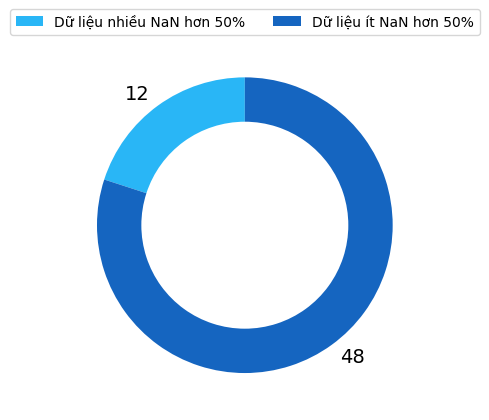

In [21]:
import matplotlib.pyplot as plt

null_counts_pandas = null_counts.toPandas()

nhieu_nan_hon_50 = len(null_counts_pandas[null_counts_pandas['Null_Percent'] > 50])
it_nan_hon_50 = len(null_counts_pandas[null_counts_pandas['Null_Percent'] <= 50])

labels = ['Dữ liệu nhiều NaN hơn 50%', 'Dữ liệu ít NaN hơn 50%']
sizes = [nhieu_nan_hon_50, it_nan_hon_50]
colors = ['#29B6F6', '#1565C0']
title = ''

fig, ax = plt.subplots()
ax.pie(sizes, labels=sizes, colors=colors, startangle=90,
       wedgeprops=dict(width=0.3), textprops={'fontsize': 14})
plt.legend(labels, loc="center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.title(title, fontsize=14)

plt.show()

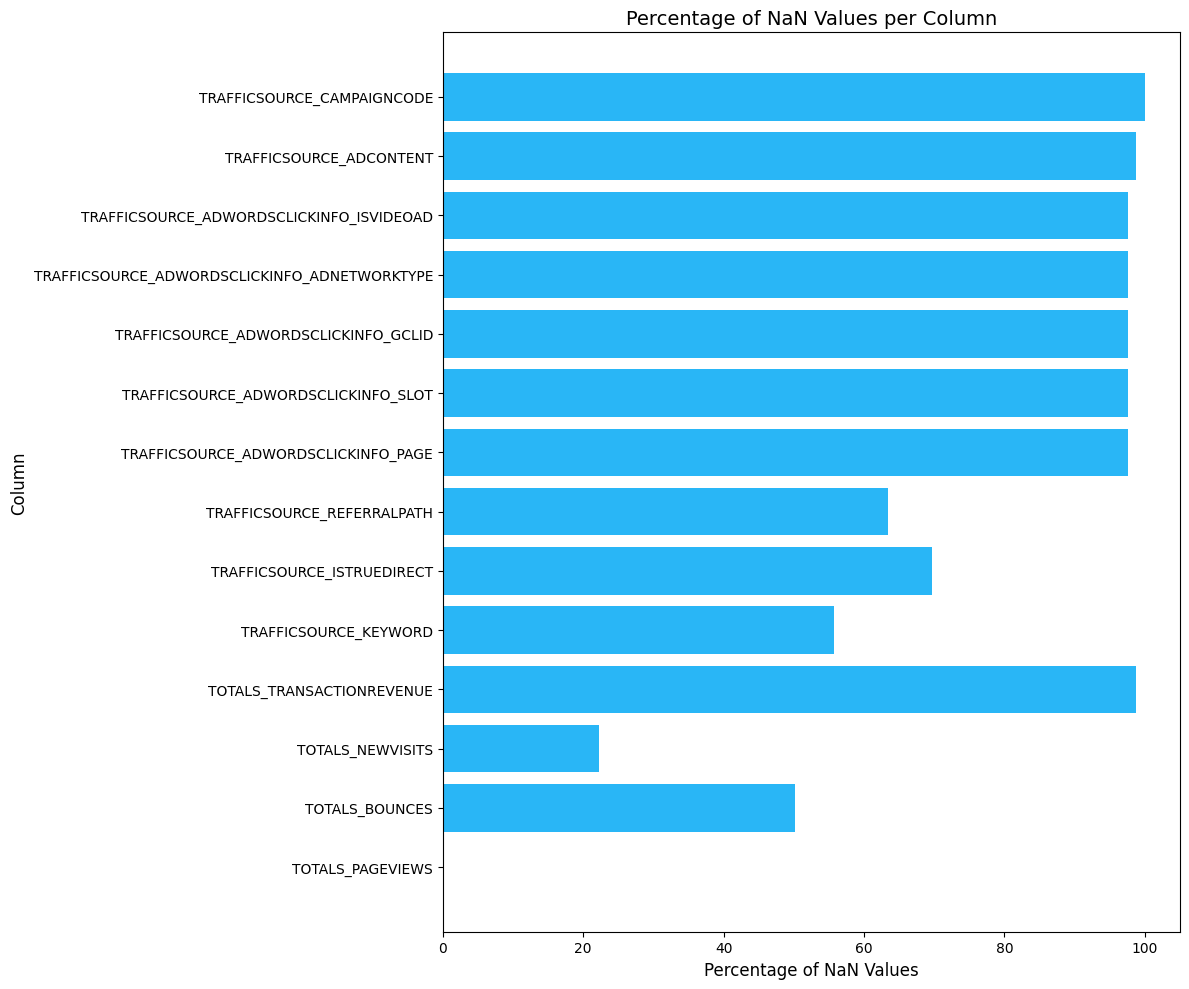

In [88]:
plt.figure(figsize=(12, 10))
null_count_ = null_counts_df.toPandas()
plt.barh(null_count_['Column'], null_count_['Null_Percent'], color='#29B6F6')

plt.ylabel("Column", fontsize=12)
plt.xlabel("Percentage of NaN Values", fontsize=12)
plt.title("Percentage of NaN Values per Column", fontsize=14)

plt.xticks(np.arange(0, 101, 20))
plt.tight_layout()
plt.show()

Fill giá trị null

In [23]:
def fill_na(df):
    df = df.withColumn("TOTALS_PAGEVIEWS", when(col("TOTALS_PAGEVIEWS").isNull(), 1).otherwise(col("TOTALS_PAGEVIEWS")).cast("integer"))
    df = df.withColumn("TOTALS_NEWVISITS", when(col("TOTALS_NEWVISITS").isNull(), 0).otherwise(col("TOTALS_NEWVISITS")).cast("integer"))
    df = df.withColumn("TOTALS_BOUNCES", when(col("TOTALS_BOUNCES").isNull(), 0).otherwise(col("TOTALS_BOUNCES")).cast("integer"))
    df = df.withColumn("TOTALS_TRANSACTIONREVENUE", when(col("TOTALS_TRANSACTIONREVENUE").isNull(), 0.0).otherwise(col("TOTALS_TRANSACTIONREVENUE")).cast("float"))
    df = df.withColumn("TRAFFICSOURCE_ISTRUEDIRECT", when(col("TRAFFICSOURCE_ISTRUEDIRECT").isNull(), lit(False)).otherwise(col("TRAFFICSOURCE_ISTRUEDIRECT")))
    df = df.withColumn("TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD", when(col("TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD").isNull(), lit(True)).otherwise(col("TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD")))
    df = df.withColumn("GEONETWORK_CITY", when(col("GEONETWORK_CITY") == "(not set)", lit("NaN")).otherwise(col("GEONETWORK_CITY")))
    df = df.withColumn("GEONETWORK_CITY", when(col("GEONETWORK_CITY").isNull(), lit("NaN")).otherwise(col("GEONETWORK_CITY")))
    return df

In [24]:
def NumericalColumns(df):
    df = df.withColumn("TOTALS_PAGEVIEWS", when(col("TOTALS_PAGEVIEWS").isNull(), 1).otherwise(col("TOTALS_PAGEVIEWS")).cast("integer"))
    df = df.withColumn("TOTALS_NEWVISITS", when(col("TOTALS_NEWVISITS").isNull(), 0).otherwise(col("TOTALS_NEWVISITS")).cast("integer"))
    df = df.withColumn("TOTALS_BOUNCES", when(col("TOTALS_BOUNCES").isNull(), 0).otherwise(col("TOTALS_BOUNCES")).cast("integer"))
    df = df.withColumn("TOTALS_TRANSACTIONREVENUE", when(col("TOTALS_TRANSACTIONREVENUE").isNull(), 0.0).otherwise(col("TOTALS_TRANSACTIONREVENUE")).cast("float"))
    df = df.withColumn("TRAFFICSOURCE_ISTRUEDIRECT", when(col("TRAFFICSOURCE_ISTRUEDIRECT").isNull(), lit(False)).otherwise(col("TRAFFICSOURCE_ISTRUEDIRECT")))
    df = df.withColumn("TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD", when(col("TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD").isNull(), lit(True)).otherwise(col("TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD")))
    df = df.withColumn("TOTALS_HITS", col("TOTALS_HITS").cast("float"))
    df = df.withColumn("TOTALS_VISIT", col("TOTALS_VISITS").cast("integer"))
    return df

Chuẩn hóa

In [25]:
def Normalizing(df):
    min_hits = df.select(min("TOTALS_HITS")).collect()[0][0]
    max_hits = df.select(max("TOTALS_HITS")).collect()[0][0]
    df = df.withColumn("TOTALS_HITS", (col("TOTALS_HITS") - min_hits) / (max_hits - min_hits))

    # Chuẩn hóa doanh thu (Revenue)
    df = df.withColumn("TOTALS_TRANSACTIONREVENUE", log1p(col("TOTALS_TRANSACTIONREVENUE")))
    return df

Constant column


In [26]:
from pyspark.sql.functions import countDistinct, col

discovering_consts = [col for col in train_df.columns if train_df.select(countDistinct(col)).collect()[0][0] == 1]
# Số cột và tên các cột có 1 giá trị duy nhất
print("Số cột chỉ có 1 giá trị duy nhất: ", len(discovering_consts), "columns")
print("Tên các cột: \n", discovering_consts)

Số cột chỉ có 1 giá trị duy nhất:  24 columns
Tên các cột: 
 ['SOCIALENGAGEMENTTYPE', 'DEVICE_BROWSERVERSION', 'DEVICE_BROWSERSIZE', 'DEVICE_OPERATINGSYSTEMVERSION', 'DEVICE_MOBILEDEVICEBRANDING', 'DEVICE_MOBILEDEVICEMODEL', 'DEVICE_MOBILEINPUTSELECTOR', 'DEVICE_MOBILEDEVICEINFO', 'DEVICE_MOBILEDEVICEMARKETINGNAME', 'DEVICE_FLASHVERSION', 'DEVICE_LANGUAGE', 'DEVICE_SCREENCOLORS', 'DEVICE_SCREENRESOLUTION', 'GEONETWORK_CITYID', 'GEONETWORK_LATITUDE', 'GEONETWORK_LONGITUDE', 'GEONETWORK_NETWORKLOCATION', 'TOTALS_VISITS', 'TOTALS_BOUNCES', 'TOTALS_NEWVISITS', 'TRAFFICSOURCE_ADWORDSCLICKINFO_CRITERIAPARAMETERS', 'TRAFFICSOURCE_ISTRUEDIRECT', 'TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD', 'TRAFFICSOURCE_CAMPAIGNCODE']


Drop các cột không cần thiết

In [27]:
to_drop = ["socialEngagementType", "device_browserVersion", "device_browserSize", "device_flashVersion", "device_language",
           "device_mobileDeviceBranding", "device_mobileDeviceInfo", "device_mobileDeviceMarketingName", "device_mobileDeviceModel",
           "device_mobileInputSelector", "device_operatingSystemVersion", "device_screenColors", "device_screenResolution",
           "geoNetwork_cityId", "geoNetwork_latitude", "geoNetwork_longitude", "geoNetwork_networkLocation",
           "trafficSource_adwordsClickInfo_criteriaParameters", "trafficSource_adwordsClickInfo_gclId", "trafficSource_campaign",
           "trafficSource_adwordsClickInfo_page", "trafficSource_referralPath", "trafficSource_adwordsClickInfo_slot",
           "trafficSource_adContent", "trafficSource_keyword"]

In [28]:
train_df = train_df.drop(*to_drop)

Số cột drop và số cột còn lại

In [29]:
print("Tổng cột bỏ: ", len(to_drop))
print("Sau khi drop: ", train_df.count(), len(train_df.columns))

Tổng cột bỏ:  25
Sau khi drop:  903653 35


In [30]:
train_df.show()

+---------------+----------+-------------------+--------------------+----------+-----------+-------------------+-----------------+----------------------+---------------+---------------------+--------------------+-----------------------+------------------+--------------------+--------------------+--------------------+------------------------+-------------+-----------+----------------+--------------+----------------+-------------------------+--------------------+--------------------+--------------------------+--------------------------------------------+----------------------------------------+--------------------------+-------+---+-----+----+---------+
|CHANNELGROUPING|      date|      FULLVISITORID|           SESSIONID|   VISITID|VISITNUMBER|     visitStartTime|   DEVICE_BROWSER|DEVICE_OPERATINGSYSTEM|DEVICE_ISMOBILE|DEVICE_DEVICECATEGORY|GEONETWORK_CONTINENT|GEONETWORK_SUBCONTINENT|GEONETWORK_COUNTRY|   GEONETWORK_REGION|    GEONETWORK_METRO|     GEONETWORK_CITY|GEONETWORK_NETWORKDOMA

In [31]:
df_train = NumericalColumns(train_df)

df_train = Normalizing(train_df)

In [32]:
df_train.describe().show()

+-------+---------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+----------------------+---------------------+--------------------+-----------------------+------------------+--------------------+--------------------+--------------------+------------------------+-------------+--------------------+------------------+--------------+----------------+-------------------------+--------------------+--------------------+--------------------------------------------+--------------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|CHANNELGROUPING|       FULLVISITORID|           SESSIONID|             VISITID|      VISITNUMBER|     visitStartTime|      DEVICE_BROWSER|DEVICE_OPERATINGSYSTEM|DEVICE_DEVICECATEGORY|GEONETWORK_CONTINENT|GEONETWORK_SUBCONTINENT|GEONETWORK_COUNTRY|   GEONETWORK_REGION|    GEONETWORK_METRO|     GEONETWORK_CITY|GEONETWORK_NETWO

In [33]:
from pyspark.sql.functions import countDistinct, col

discovering_consts = [col for col in train_df.columns if train_df.select(countDistinct(col)).collect()[0][0] == 1]
print("Số cột chỉ có 1 giá trị duy nhất: ", len(discovering_consts), "cột")
print("Tên của các cột: \n", discovering_consts)

Số cột chỉ có 1 giá trị duy nhất:  6 cột
Tên của các cột: 
 ['TOTALS_VISITS', 'TOTALS_BOUNCES', 'TOTALS_NEWVISITS', 'TRAFFICSOURCE_ISTRUEDIRECT', 'TRAFFICSOURCE_ADWORDSCLICKINFO_ISVIDEOAD', 'TRAFFICSOURCE_CAMPAIGNCODE']


Số lượng giá trị trong từng cột

In [34]:
df_train.select([countDistinct(c).alias(c) for c in df_train.columns]).show()

+---------------+----+-------------+---------+-------+-----------+--------------+--------------+----------------------+---------------+---------------------+--------------------+-----------------------+------------------+-----------------+----------------+---------------+------------------------+-------------+-----------+----------------+--------------+----------------+-------------------------+--------------------+--------------------+--------------------------+--------------------------------------------+----------------------------------------+--------------------------+-------+---+-----+----+---------+
|CHANNELGROUPING|date|FULLVISITORID|SESSIONID|VISITID|VISITNUMBER|visitStartTime|DEVICE_BROWSER|DEVICE_OPERATINGSYSTEM|DEVICE_ISMOBILE|DEVICE_DEVICECATEGORY|GEONETWORK_CONTINENT|GEONETWORK_SUBCONTINENT|GEONETWORK_COUNTRY|GEONETWORK_REGION|GEONETWORK_METRO|GEONETWORK_CITY|GEONETWORK_NETWORKDOMAIN|TOTALS_VISITS|TOTALS_HITS|TOTALS_PAGEVIEWS|TOTALS_BOUNCES|TOTALS_NEWVISITS|TOTALS_TRANSAC

#2. Mô tả các biến

Phân phối

In [35]:
df_filtered = df_train.filter(col('TOTALS_TRANSACTIONREVENUE') > 0)

min_revenue = df_filtered.agg({'TOTALS_TRANSACTIONREVENUE': 'min'}).collect()[0][0]
mean_revenue = df_filtered.agg({'TOTALS_TRANSACTIONREVENUE': 'avg'}).collect()[0][0]
median_revenue = df_filtered.approxQuantile('TOTALS_TRANSACTIONREVENUE', [0.5], 0)[0]
max_revenue = df_filtered.agg({'TOTALS_TRANSACTIONREVENUE': 'max'}).collect()[0][0]

print(f"Giá trị tối thiểu Transaction Revenue: {min_revenue}")
print(f"Giá trị trung bình Transaction Revenue: {mean_revenue}")
print(f"Giá trị trung vị Transaction Revenue: {median_revenue}")
print(f"Giá trị tối đa Transaction Revenue: {max_revenue}")


Giá trị tối thiểu Transaction Revenue: 9.210440366976517
Giá trị trung bình Transaction Revenue: 17.823362302985547
Giá trị trung vị Transaction Revenue: 17.716472636255443
Giá trị tối đa Transaction Revenue: 23.86437469605166


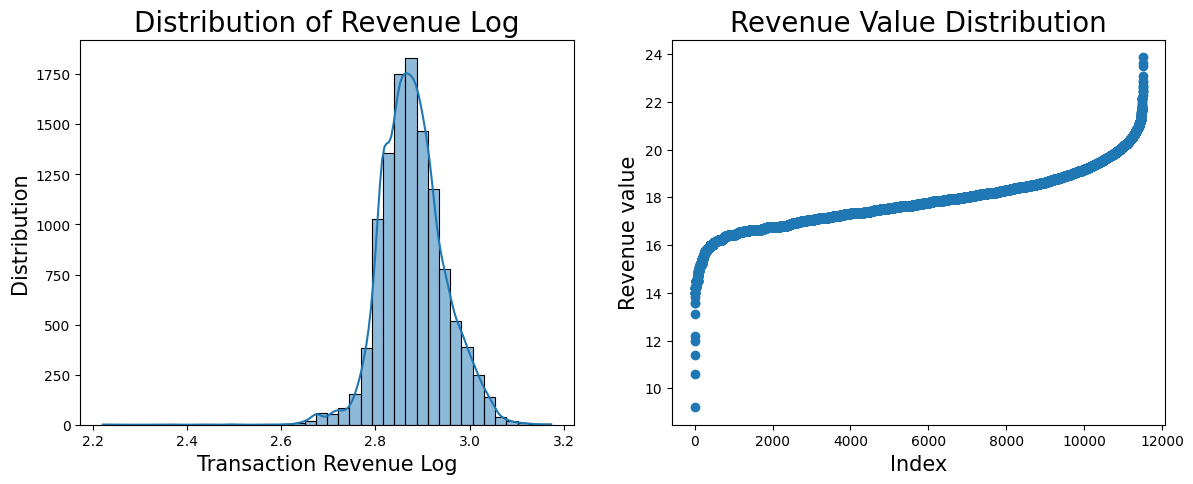

In [36]:
# Lấy dữ liệu đã được lọc từ PySpark DataFrame, chuyển thành danh sách
revenue_values = df_filtered.select('TOTALS_TRANSACTIONREVENUE').rdd.flatMap(lambda x: x).collect()


plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
sns.histplot(np.log(np.array(revenue_values) + 0.01), bins=40, kde=True)
plt.xlabel('Transaction Revenue Log', fontsize=15)
plt.ylabel('Distribution', fontsize=15)
plt.title("Distribution of Revenue Log", fontsize=20)


plt.subplot(1, 2, 2)
plt.scatter(range(len(revenue_values)), np.sort(revenue_values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('Revenue value', fontsize=15)
plt.title("Revenue Value Distribution", fontsize=20)

plt.show()


Phân phối tương đối tốt, có giá trị rất cao về Transactions Revenue.

Tôi sẽ xem độ nhọn (kurtosis) và độ lệch (Skewness) của doanh thu giao dịch

Độ lệch:

  Là mức độ biến dạng từ đường cong chuông đối xứng hoặc phân phối chuẩn. Nó đo lường sự thiếu đối xứng trong phân phối dữ liệu.

  Nó phân biệt các giá trị cực trị trong một đuôi so với đuôi kia. Phân phối đối xứng sẽ có độ lệch là 0.

  Độ lệch dương có nghĩa là khi đuôi ở phía bên phải của phân phối dài hơn hoặc béo hơn. Giá trị trung bình và trung vị sẽ lớn hơn mốt.

  Độ lệch âm là khi đuôi ở phía bên trái của phân phối dài hơn hoặc béo hơn đuôi ở phía bên phải. Giá trị trung bình và trung vị sẽ nhỏ hơn mốt.


Vậy, khi nào độ lệch là quá nhiều?

  Nguyên tắc chung là:

  Nếu độ lệch nằm trong khoảng -0,5 đến 0,5, dữ liệu khá đối xứng.

  Nếu độ lệch nằm trong khoảng -1 đến -0,5 (độ lệch âm) hoặc giữa 0,5 và 1 (độ lệch dương), dữ liệu bị lệch vừa phải.

  Nếu độ lệch nhỏ hơn -1 (độ lệch âm) hoặc lớn hơn 1 (độ lệch dương), dữ liệu bị lệch rất nhiều.

Độ nhọn:

Độ nhọn liên quan đến đuôi của phân phối — không phải độ nhọn hay độ phẳng. Nó được sử dụng để mô tả các giá trị cực trị trong một đuôi so với đuôi kia.
Trên thực tế, nó là thước đo các giá trị ngoại lai có trong phân phối.

Độ nhọn cao trong một tập dữ liệu là một chỉ báo cho thấy dữ liệu có đuôi nặng hoặc giá trị ngoại lai. Nếu có độ nhọn cao, thì chúng ta cần phải điều tra tại sao chúng ta lại có quá nhiều giá trị ngoại lai. Nó chỉ ra rất nhiều thứ, có thể là nhập dữ liệu sai hoặc những thứ khác. Hãy điều tra!
Độ nhọn thấp trong một tập dữ liệu là một chỉ báo cho thấy dữ liệu có đuôi nhẹ hoặc thiếu giá trị ngoại lai. Nếu chúng ta có độ nhọn thấp (quá tốt để có thể là sự thật), thì chúng ta cũng cần phải điều tra và cắt bớt tập dữ liệu khỏi các kết quả không mong muốn

In [37]:
from pyspark.sql.functions import kurtosis, skewness

filtered_df = df_train.filter(df_train['TOTALS_TRANSACTIONREVENUE'] > 0)

kurtosis_value = filtered_df.select(kurtosis("TOTALS_TRANSACTIONREVENUE")).collect()[0][0]
skewness_value = filtered_df.select(skewness("TOTALS_TRANSACTIONREVENUE")).collect()[0][0]

print('Độ nhọn dư thừa của phân phối chuẩn: {}'.format(kurtosis_value))
print('Độ lệch của phân phối chuẩn: {}'.format(skewness_value))

Độ nhọn dư thừa của phân phối chuẩn: 1.1610188903215377
Độ lệch của phân phối chuẩn: 0.3375230660214753


Dữ liệu của chúng tôi khá đối xứng và có độ nhọn cao.

Tôi sẽ xem có bao nhiêu giá trị ngoại lệ trong tập dữ liệu này.

In [38]:
def CalcOutliers(df_num):
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    cut = data_std * 3
    lower, upper = data_mean - cut, data_mean + cut
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]
    outliers_removed = [x for x in df_num if x > lower and x < upper]


    print('Giá trị ngoại lai thấp nhất: %d' % len(outliers_lower))
    print('Giá trị ngoại lai trên: %d' % len(outliers_higher))
    print('Các giá trị ngoại lai: %d' % len(outliers_total))
    print('Quan sát không phải ngoại lệ: %d' % len(outliers_removed))
    if len(outliers_removed) > 0 :
        print("Tổng phần trăm của các giá trị ngoại lệ: ", round((len(outliers_total) / len(outliers_removed) )*100, 4))
    else:
        print("Tổng phần trăm của các giá trị ngoại lệ: ", 0)
    return


In [39]:
def CalcOutliers(df_num):
    df_num_np = np.array(df_num.collect())
    df_num_np = df_num_np[df_num_np != None]
    if df_num_np.size == 0:
        print("All values are None. Cannot calculate outliers.")
        return

    data_mean, data_std = np.mean(df_num_np), np.std(df_num_np)
    cut = data_std * 3
    lower, upper = data_mean - cut, data_mean + cut
    outliers_lower = [x for x in df_num_np if x < lower]
    outliers_higher = [x for x in df_num_np if x > upper]
    outliers_total = [x for x in df_num_np if x < lower or x > upper]
    outliers_removed = [x for x in df_num_np if x > lower and x < upper]

    print('Giá trị ngoại lai thấp nhất: %d' % len(outliers_lower))
    print('Giá trị ngoại lai trên: %d' % len(outliers_higher))
    print('Các giá trị ngoại lai: %d' % len(outliers_total))
    print('Quan sát không phải ngoại lệ: %d' % len(outliers_removed))
    if len(outliers_removed) > 0:
        print("Tổng phần trăm của các giá trị ngoại lệ: ", round((len(outliers_total) / len(outliers_removed)) * 100, 4))
    else:
        print("Tổng phần trăm của các giá trị ngoại lệ: ", 0)
    return

In [40]:
# CalcOutliers(df_train.select('TOTALS_TRANSACTIONREVENUE'))

In [41]:
# CalcOutliers(df_train.select('TOTALS_PAGEVIEWS'))

Top 10 trình duyệt có tỷ lệ vào nhiều nhất

Tỷ lệ sử dụng trình duyệt: 
+-----------------+------+
|DEVICE_BROWSER   |count |
+-----------------+------+
|Chrome           |620364|
|Safari           |182245|
|Firefox          |37069 |
|Internet Explorer|19375 |
|Edge             |10205 |
|Android Webview  |7865  |
|Safari (in-app)  |6850  |
+-----------------+------+
only showing top 7 rows



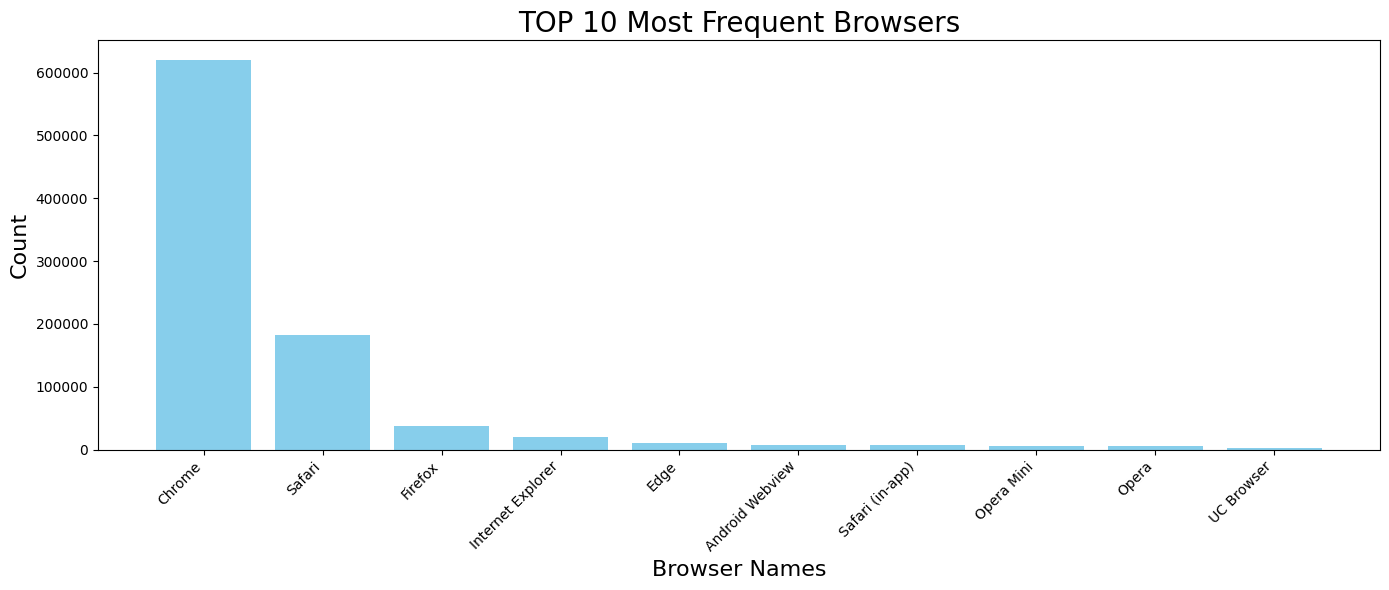

In [42]:
from pyspark.sql.functions import desc, collect_list

browser_counts = df_train.groupBy('DEVICE_BROWSER').count().orderBy(desc('count'))
print("Tỷ lệ sử dụng trình duyệt: ")
browser_counts.show(7, truncate=False)


top_10_browsers = browser_counts.limit(10).select("DEVICE_BROWSER", "count").collect()
browsers = [row["DEVICE_BROWSER"] for row in top_10_browsers]
counts = [row["count"] for row in top_10_browsers]


plt.figure(figsize=(14, 6))
plt.bar(browsers, counts, color='skyblue')
plt.title("TOP 10 Most Frequent Browsers", fontsize=20)
plt.xlabel("Browser Names", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Trong 5 Browsers hàng đầu, chúng tôi có hơn 94% so với tổng số

TOP 1 - CHROME - 69,08%

TOP 2 - SAFARI - 20,04%

TOP 3 - FIREFOX - 3,77%

Chrome là trình duyệt được sử dụng nhiều nhất, tiếp theo là Safari và firefox.

Liên hệ giữa revenue và browsers

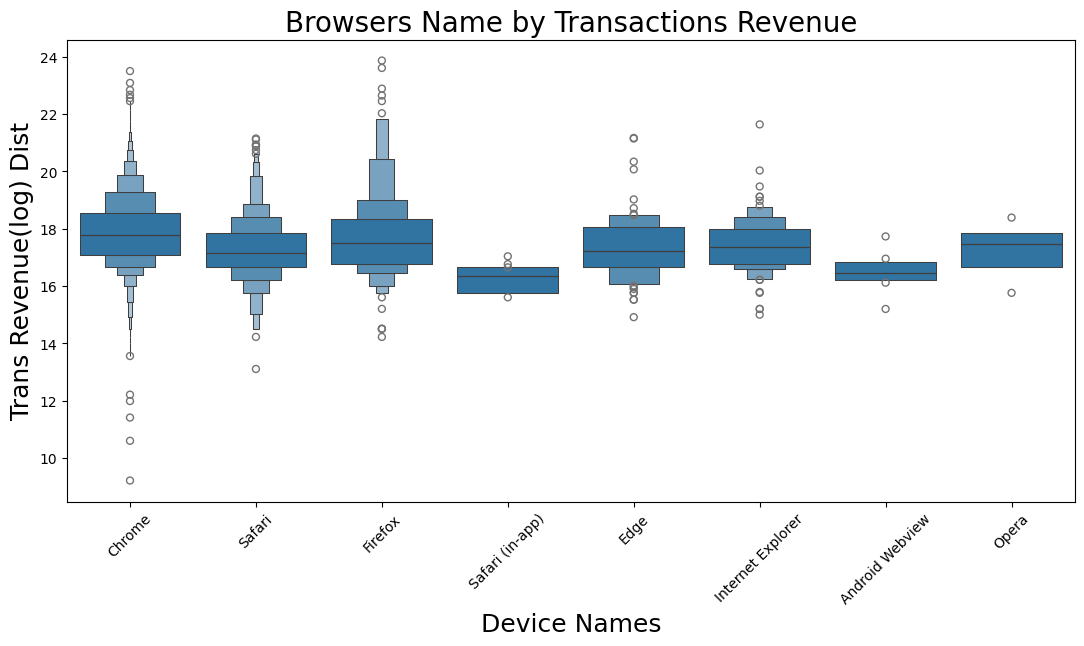

In [43]:
browser_counts = df_train.groupBy('DEVICE_BROWSER').count().orderBy(desc('count'))
top_10_browsers = browser_counts.limit(10).select("DEVICE_BROWSER").rdd.flatMap(lambda x: x).collect()

r_b_df = df_train.filter(
    (col('DEVICE_BROWSER').isin(top_10_browsers)) & (col('TOTALS_TRANSACTIONREVENUE') > 0)
)

r_b_df = r_b_df.toPandas()  # Chỉ đổi để dùng seaborn

plt.figure(figsize=(13, 6))
g1 = sns.boxenplot(x='DEVICE_BROWSER', y='TOTALS_TRANSACTIONREVENUE', data=r_b_df)
g1.set_title('Browsers Name by Transactions Revenue', fontsize=20)
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g1.set_xlabel('Device Names', fontsize=18)
g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18)
plt.show()

Chrome có giá trị cao nhất nói chung nhưng giá trị giao dịch cao nhất được thực hiện trên Firefox.

Chúng ta có thể thấy một lượng bán "nhỏ" nhưng nhất quán trong Safari. Ngoài ra, IE và Edge cung cấp một số kết quả cho Google;

Top 10 Channel Grouping được sử dụng nhiều nhất

Percentual of Channel Grouping used:
+---------------+------+------------------+
|CHANNELGROUPING| count|        Percentage|
+---------------+------+------------------+
| Organic Search|381561| 42.22428299358271|
|         Social|226117|25.022547371612774|
|         Direct|143026|15.827535569516174|
|       Referral|104838|11.601577154062454|
|    Paid Search| 25326| 2.802624458724754|
+---------------+------+------------------+
only showing top 5 rows



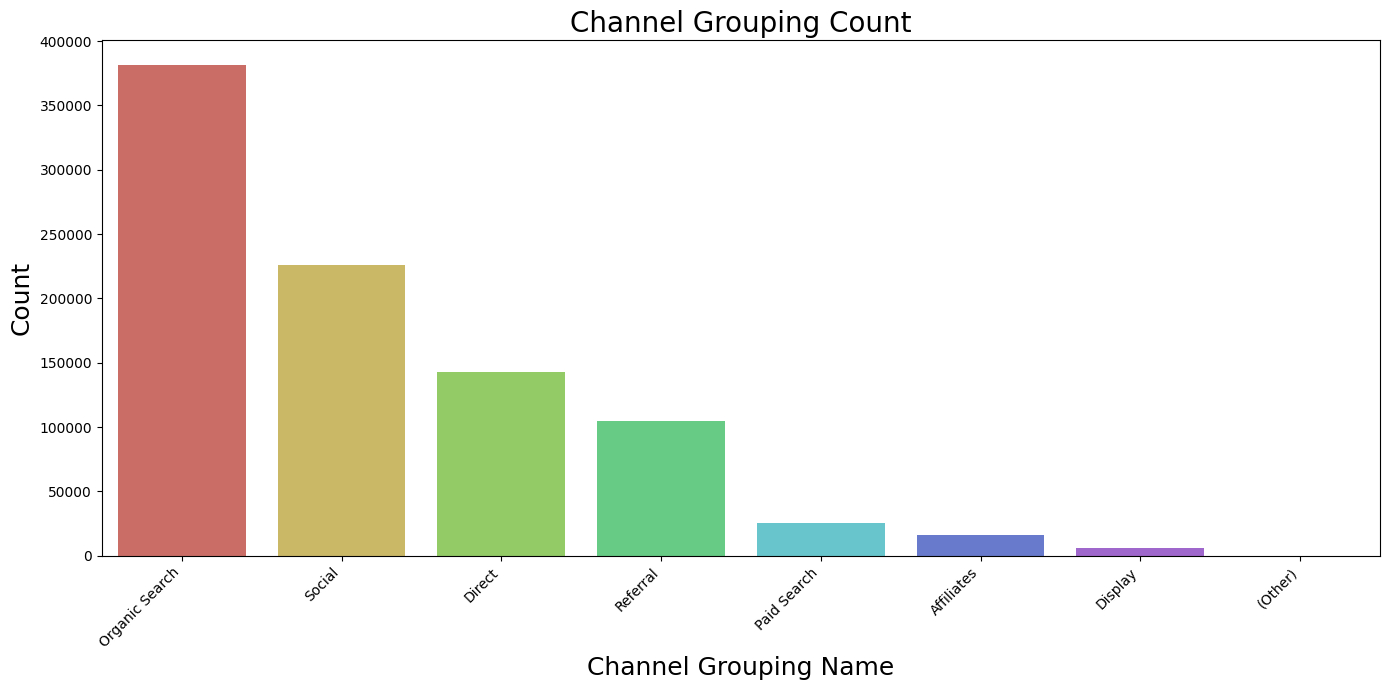

In [44]:
channel_grouping_counts = df_train.groupBy("CHANNELGROUPING").count().orderBy(desc("count"))
total_count = df_train.count()
channel_grouping_percentages = channel_grouping_counts.withColumn(
    "Percentage", (col("count") / total_count) * 100
)

print("Percentual of Channel Grouping used:")
channel_grouping_percentages.show(5)
channel_grouping_pd = channel_grouping_counts.toPandas()  # Chỉ dùng cho plotting

plt.figure(figsize=(14, 7))
sns.barplot(x="CHANNELGROUPING", y="count", data=channel_grouping_pd, palette="hls")
plt.title("Channel Grouping Count", fontsize=20)
plt.xlabel("Channel Grouping Name", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top 5 Grouping Channels đại diện cho 97% tổng giá trị. Tương ứng:

TOP 1 => Organic Search - 42%

TOP 2 => Social - 25%

TOP 3 => Direct  - 15%

TOP 4 => Referral - 11%

TOP 5 => Paid Search - 2%


Liên hệ giữa channel và browsers


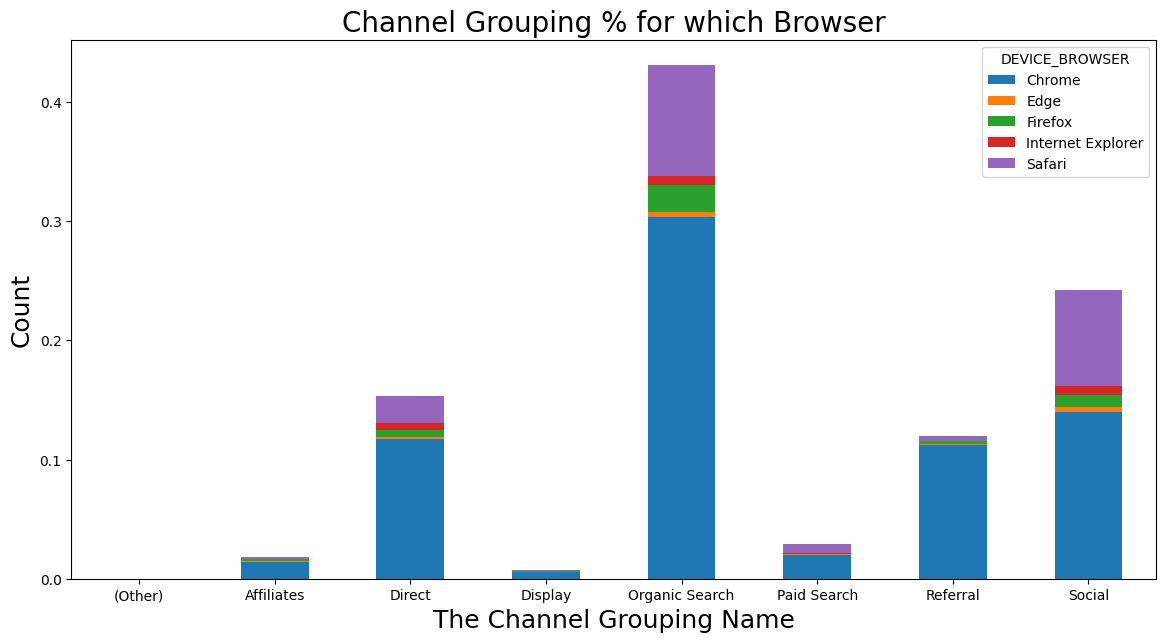

In [45]:
from pyspark.sql.functions import count, desc

browser_counts = df_train.groupBy('DEVICE_BROWSER').agg(count("*").alias("count")).orderBy(desc("count"))
top_5_browsers = [row['DEVICE_BROWSER'] for row in browser_counts.limit(5).collect()]
filtered_df = df_train.filter(df_train['DEVICE_BROWSER'].isin(top_5_browsers))


df_train_pd = filtered_df.toPandas() #chỉ dùng cho plotting


crosstab_eda = pd.crosstab(index=df_train_pd['CHANNELGROUPING'], normalize=True,
                           columns=df_train_pd['DEVICE_BROWSER'])

crosstab_eda.plot(kind="bar", figsize=(14, 7), stacked=True)
plt.title("Channel Grouping % for which Browser", fontsize=20)
plt.xlabel("The Channel Grouping Name", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(rotation=0)
plt.show()

Tổng số người dùng trên từng channel và doang thu của các channel

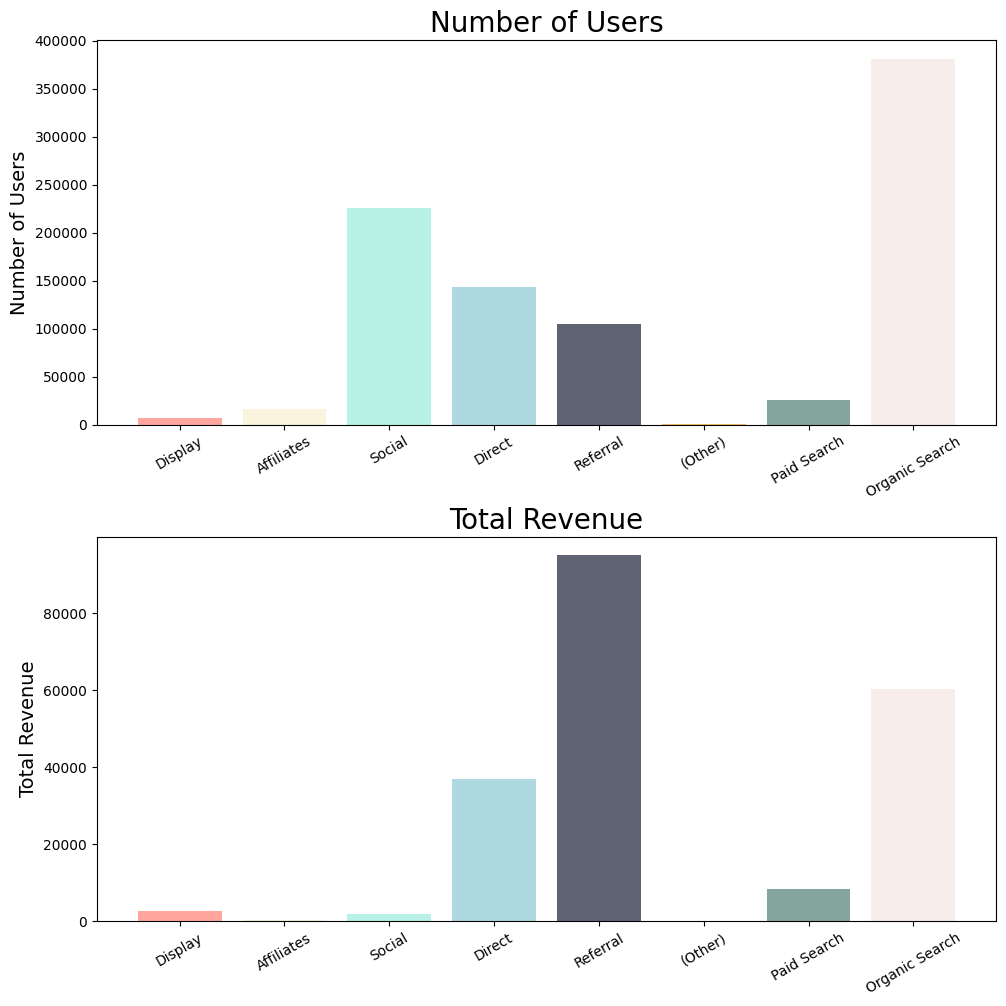

In [46]:
from pyspark.sql.functions import count, sum, avg, first, collect_list

group = df_train.groupBy('CHANNELGROUPING').agg(
    count("*").alias("count"),
    sum("TOTALS_TRANSACTIONREVENUE").alias("sum"),
    avg("TOTALS_TRANSACTIONREVENUE").alias("mean")
)

group_data = group.collect()  # Collect data to driver for plotting


channel_grouping = [row['CHANNELGROUPING'] for row in group_data]
user_counts = [row['count'] for row in group_data]
total_revenue = [row['sum'] for row in group_data]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.bar(channel_grouping, user_counts, color=["#ffa69e", "#faf3dd", "#b8f2e6", "#aed9e0", "#5e6472", '#f6bd60', '#84a59d', '#f8edeb'])
ax1.set_title('Number of Users', fontsize=20)
ax1.set_ylabel('Number of Users', fontsize=14)
ax1.set_xticklabels(channel_grouping, rotation=30, fontsize=10)


ax2.bar(channel_grouping, total_revenue, color=["#ffa69e", "#faf3dd", "#b8f2e6", "#aed9e0", "#5e6472", '#f6bd60', '#84a59d', '#f8edeb'])
ax2.set_title('Total Revenue', fontsize=20)
ax2.set_ylabel('Total Revenue', fontsize=14)
ax2.set_xticklabels(channel_grouping, rotation=30, fontsize=10)
fig.tight_layout(pad=0.5)
plt.show()

Top loại thiết bị sử dụng nhiều nhất

Percentual of Operational System: 
+----------------------+------+
|DEVICE_OPERATINGSYSTEM|count |
+----------------------+------+
|Windows               |350072|
|Macintosh             |253938|
|Android               |123892|
|iOS                   |107665|
|Linux                 |35034 |
+----------------------+------+
only showing top 5 rows



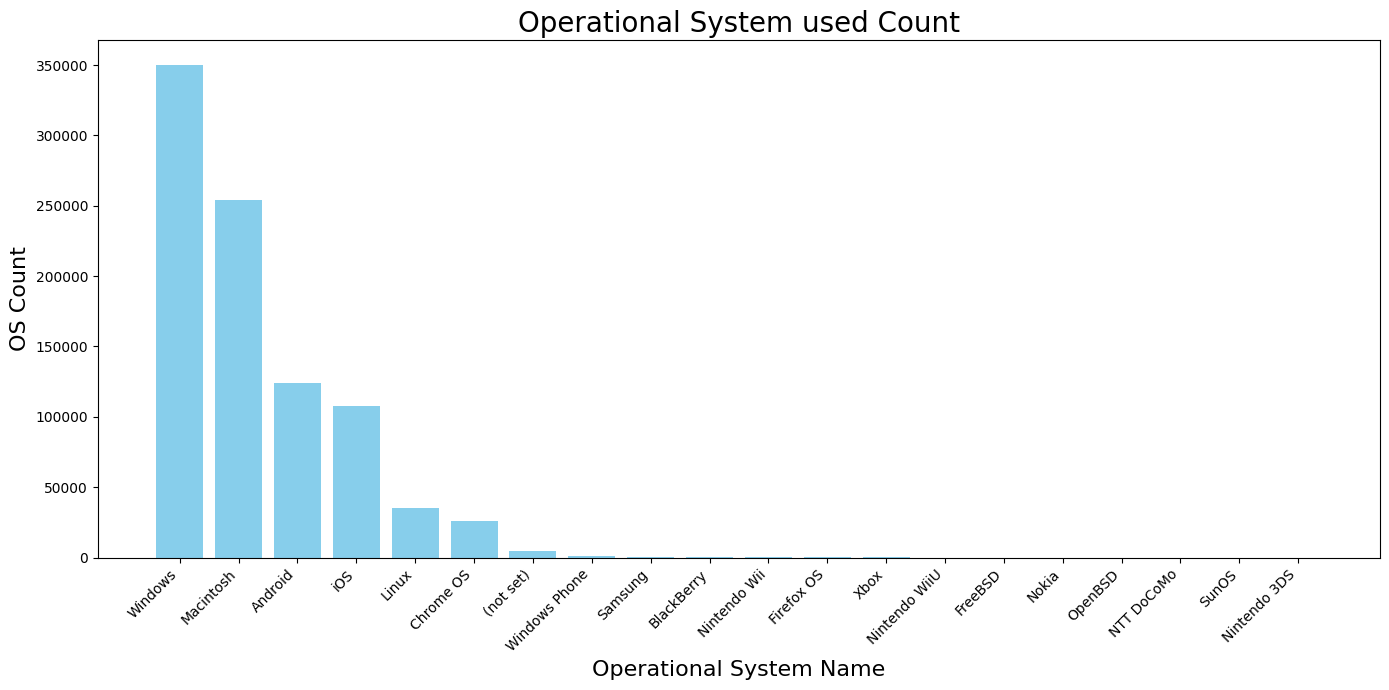

In [47]:
print("Percentual of Operational System: ")
op_system_counts = df_train.groupBy("DEVICE_OPERATINGSYSTEM").agg(count("*").alias("count")).orderBy(desc("count"))

op_system_counts.show(5, truncate=False)


op_system_data = op_system_counts.collect()
op_systems = [row["DEVICE_OPERATINGSYSTEM"] for row in op_system_data]
counts = [row["count"] for row in op_system_data]


plt.figure(figsize=(14, 7))
plt.bar(op_systems, counts, color='skyblue')
plt.title("Operational System used Count", fontsize=20)
plt.xlabel("Operational System Name", fontsize=16)
plt.ylabel("OS Count", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TOP 5 của Operational System tương ứng với 96%.

TOP 1 => Windows - 38.75%

TOP 2 => Macintosh - 28.04%

TOP 3 => Android - 14.15%

TOP 4 => iOS - 11.75%

TOP 5 => Linux - 3.91%

Trình duyệt được sử dụng nhiều nhất theo hệ điều hành

In [48]:
top_6_os = df_train.groupBy("DEVICE_OPERATINGSYSTEM").agg(count("*").alias("count")).orderBy(desc("count")) \
    .limit(6).select("DEVICE_OPERATINGSYSTEM").rdd.flatMap(lambda x: x).collect()

top_5_browsers = df_train.groupBy("DEVICE_BROWSER").agg(count("*").alias("count")).orderBy(desc("count")) \
    .limit(5).select("DEVICE_BROWSER").rdd.flatMap(lambda x: x).collect()

filtered_df = df_train.filter(
    (col('DEVICE_OPERATINGSYSTEM').isin(top_6_os)) &
    (col('DEVICE_BROWSER').isin(top_5_browsers))
)

In [49]:
from pyspark.sql.functions import first

crosstab_df = filtered_df.groupBy("DEVICE_OPERATINGSYSTEM", "DEVICE_BROWSER").agg(count("*").alias("count")) \
    .groupBy("DEVICE_OPERATINGSYSTEM").pivot("DEVICE_BROWSER").agg(first("count"))

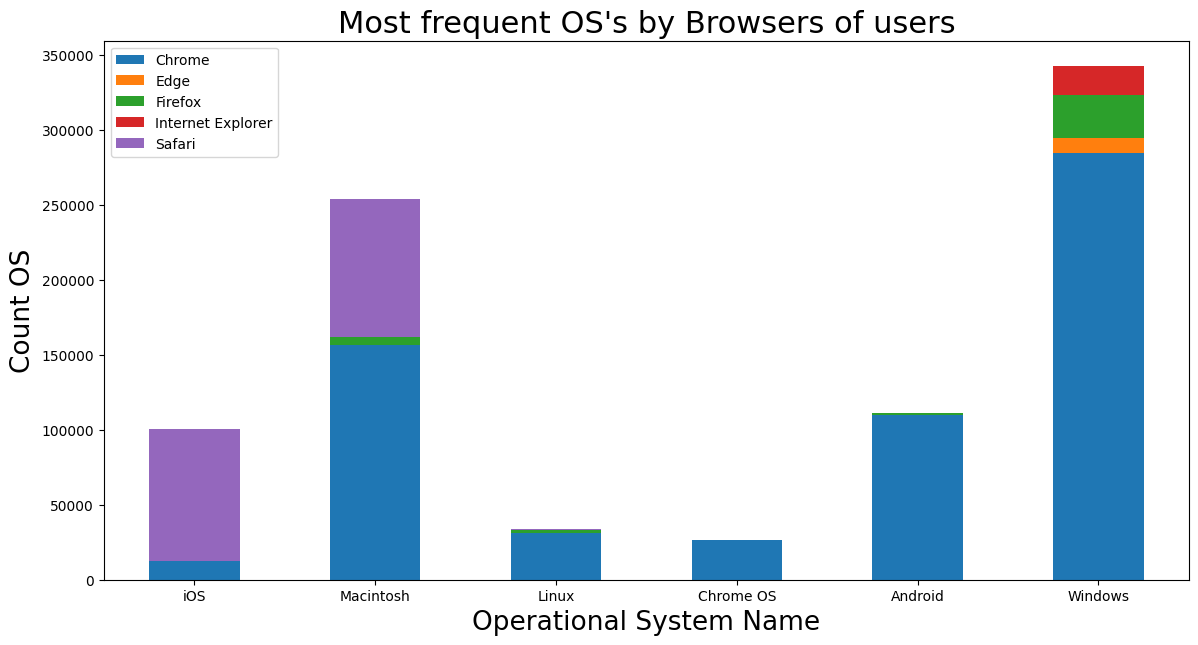

In [50]:

crosstab_pd = crosstab_df.toPandas()
crosstab_pd.set_index("DEVICE_OPERATINGSYSTEM", inplace=True) # chỉ dùng cho plotting


crosstab_pd.plot(kind="bar", figsize=(14, 7), stacked=True)
plt.title("Most frequent OS's by Browsers of users", fontsize=22)
plt.xlabel("Operational System Name", fontsize=19)
plt.ylabel("Count OS", fontsize=19)
plt.xticks(rotation=0)
plt.show()

Có thể thấy rõ ràng là Chrome được sử dụng nhiều nhất trong tất cả các hệ điều hành, ít hơn trong iOS, đó là hệ điều hành di động.

Tôi sẽ xem liệu chúng ta có thể thấy sự khác biệt giữa Doanh thu của các giao dịch khác nhau không

Phân phối Doanh thu giao dịch theo từng hệ điều hành

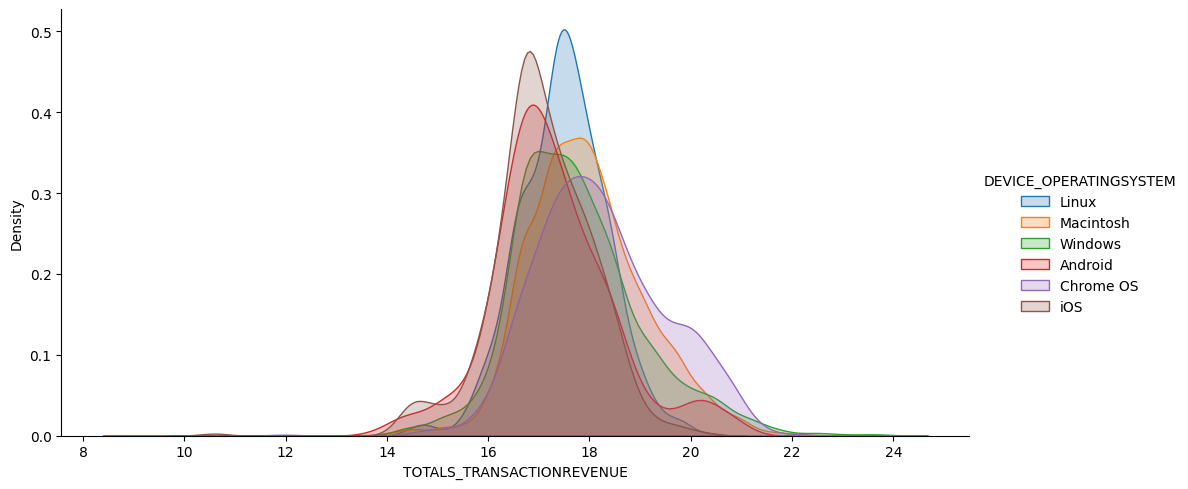

In [51]:
top_6_os = df_train.groupBy("DEVICE_OPERATINGSYSTEM").agg(count("*").alias("count")).orderBy(desc("count")) \
    .limit(6).select("DEVICE_OPERATINGSYSTEM").rdd.flatMap(lambda x: x).collect()

filtered_df = df_train.filter(
    (col('DEVICE_OPERATINGSYSTEM').isin(top_6_os)) & (col('TOTALS_TRANSACTIONREVENUE') > 0)
)

filtered_pd = filtered_df.select("DEVICE_OPERATINGSYSTEM", "TOTALS_TRANSACTIONREVENUE").toPandas() #chỉ dùng để plotting


(sns.FacetGrid(filtered_pd, hue='DEVICE_OPERATINGSYSTEM', height=5, aspect=2)
  .map(sns.kdeplot, 'TOTALS_TRANSACTIONREVENUE', shade=True)
 .add_legend()
)
plt.show()

Theo loại thiết bị

Percentual of Operational System: 
+---------------------+------+-----------------+
|DEVICE_DEVICECATEGORY| count|       Percentage|
+---------------------+------+-----------------+
|              desktop|664479|73.53253959207792|
|               mobile|208725|23.09791479694086|
|               tablet| 30449|3.369545610981206|
+---------------------+------+-----------------+



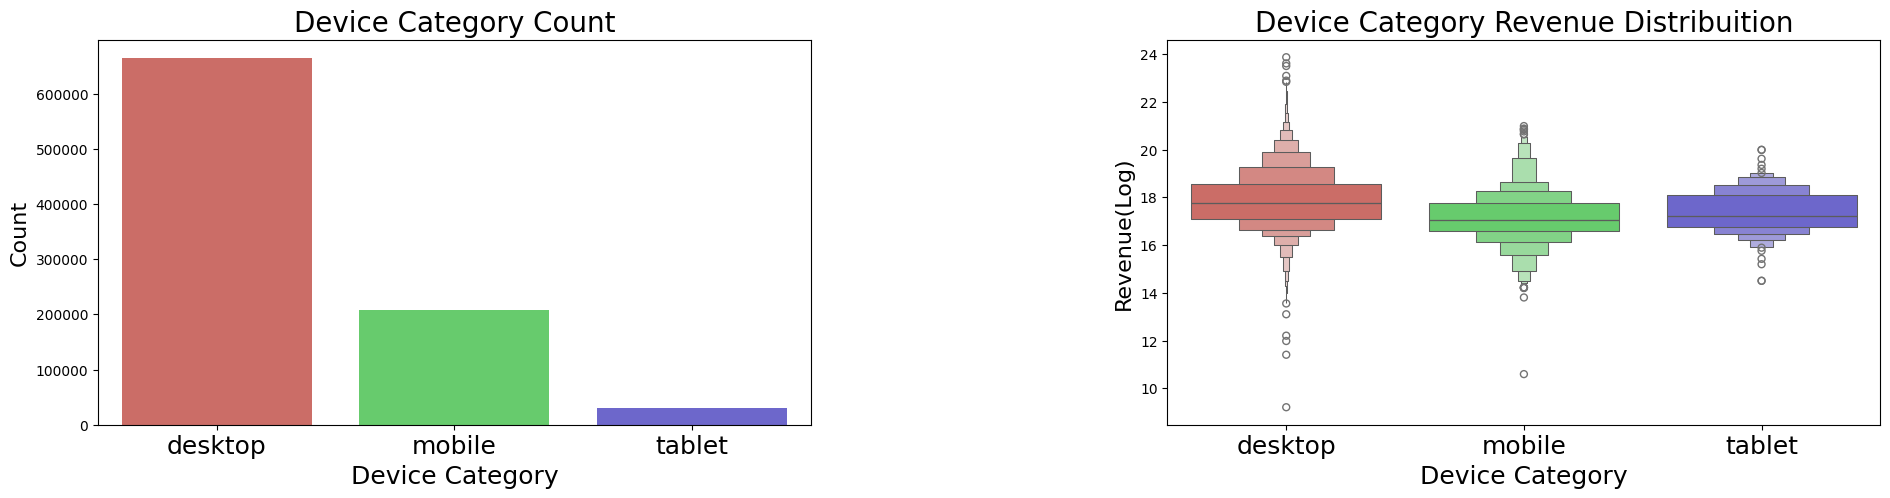

In [52]:
from pyspark.sql.functions import count, when, col, log1p

device_category_counts = df_train.groupBy("DEVICE_DEVICECATEGORY").agg(count("*").alias("count"))
total_count = df_train.count()
device_category_percentages = device_category_counts.withColumn(
    "Percentage", (col("count") / total_count) * 100
)
print("Percentual of Operational System: ")
device_category_percentages.show()



device_category_pd = device_category_counts.toPandas() #Chỉ dùng để plotting

plt.figure(figsize=(23, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="DEVICE_DEVICECATEGORY", y="count", data=device_category_pd, palette="hls")
plt.title("Device Category Count", fontsize=20)
plt.xlabel("Device Category", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=18)



filtered_df_pd = df_train.filter(col('TOTALS_TRANSACTIONREVENUE') > 0).toPandas() #chỉ dùng để plotting

plt.subplot(1, 2, 2)
sns.boxenplot(x="DEVICE_DEVICECATEGORY", y='TOTALS_TRANSACTIONREVENUE', data=filtered_df_pd, palette="hls")
plt.title("Device Category Revenue Distribuition", fontsize=20)
plt.xlabel("Device Category", fontsize=18)
plt.ylabel("Revenue(Log)", fontsize=16)
plt.xticks(fontsize=18)
plt.subplots_adjust(hspace=0.9, wspace=0.5)
plt.show()

Theo phần trăm, chúng ta có thể thấy rằng:

desktop chiếm 73.5%

mobile chiếm 23.12%

tablet chiếm 3.38%

Ta có thể thấy rằng doanh thu hầu như đều từ máy tính bàn.

Sự phân phối khác biệt giữa các thiết bị

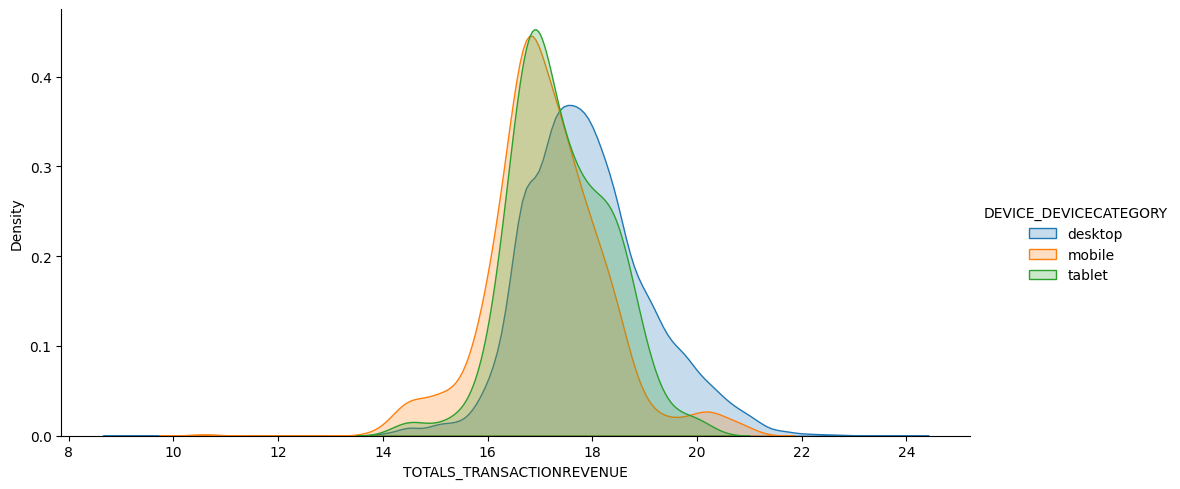

In [53]:
top_6_os = df_train.groupBy("DEVICE_DEVICECATEGORY").agg(count("*").alias("count")).orderBy(desc("count")) \
    .limit(6).select("DEVICE_DEVICECATEGORY").rdd.flatMap(lambda x: x).collect()

filtered_df = df_train.filter(
    (col('DEVICE_DEVICECATEGORY').isin(top_6_os)) & (col('TOTALS_TRANSACTIONREVENUE') > 0)
)

filtered_pd = filtered_df.select("DEVICE_DEVICECATEGORY", "TOTALS_TRANSACTIONREVENUE").toPandas() #dùng để plotting


(sns.FacetGrid(filtered_pd, hue='DEVICE_DEVICECATEGORY', height=5, aspect=2)
  .map(sns.kdeplot, 'TOTALS_TRANSACTIONREVENUE', shade=True)
 .add_legend()
)
plt.show()

Hệ điều hành theo loại thiết bị

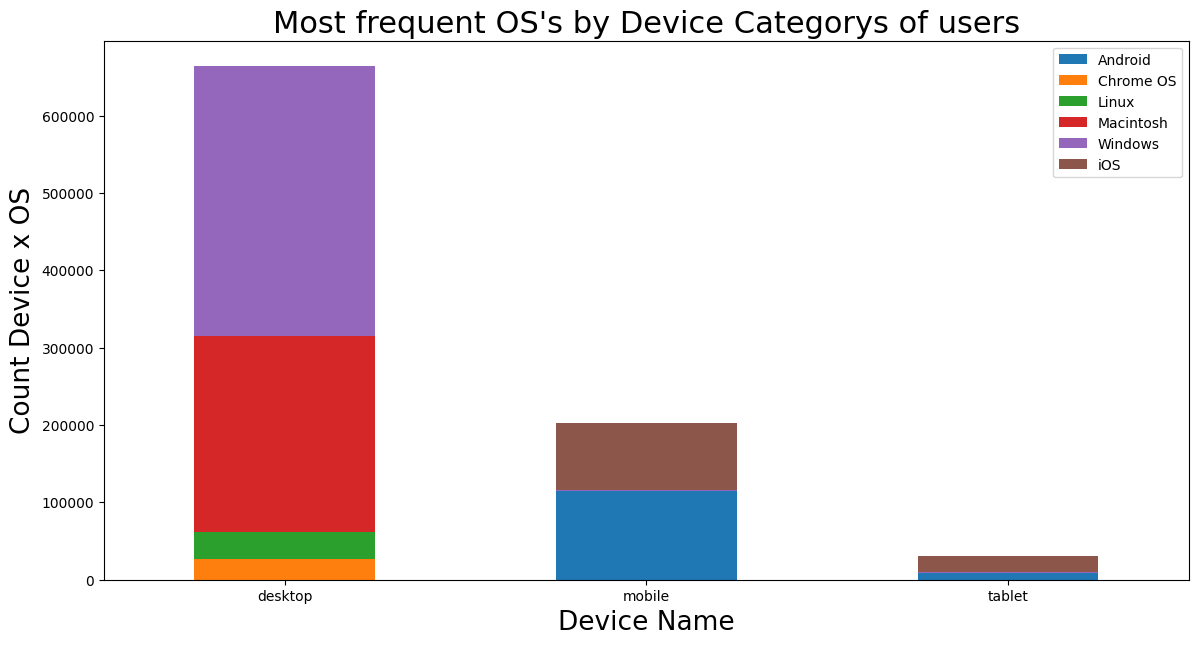

In [54]:
top_6_os = df_train.groupBy("DEVICE_OPERATINGSYSTEM").agg(count("*").alias("count")).orderBy(desc("count")) \
    .limit(6).select("DEVICE_OPERATINGSYSTEM").rdd.flatMap(lambda x: x).collect()


filtered_df = df_train.filter(
    (col('DEVICE_OPERATINGSYSTEM').isin(top_6_os)) & (col('DEVICE_DEVICECATEGORY').isNotNull())
)
crosstab_df = filtered_df.groupBy("DEVICE_DEVICECATEGORY", "DEVICE_OPERATINGSYSTEM").agg(count("*").alias("count")) \
    .groupBy("DEVICE_DEVICECATEGORY").pivot("DEVICE_OPERATINGSYSTEM").agg(first("count"))



crosstab_pd = crosstab_df.toPandas() #chỉ dùng để plotting

crosstab_pd.set_index("DEVICE_DEVICECATEGORY", inplace=True)
crosstab_pd.plot(kind="bar", figsize=(14, 7), stacked=True)
plt.title("Most frequent OS's by Device Categorys of users", fontsize=22)
plt.xlabel("Device Name", fontsize=19)
plt.ylabel("Count Device x OS", fontsize=19)
plt.xticks(rotation=0)
plt.show()

Số lượng truy cập theo từng đất nước

Description of SubContinent count: 
+-----------------------+------+
|GEONETWORK_SUBCONTINENT|count |
+-----------------------+------+
|Northern America       |390657|
|Southeast Asia         |77800 |
|Southern Asia          |59321 |
|Western Europe         |59114 |
|Northern Europe        |58168 |
|Eastern Asia           |46919 |
|Eastern Europe         |45249 |
|South America          |41731 |
+-----------------------+------+
only showing top 8 rows



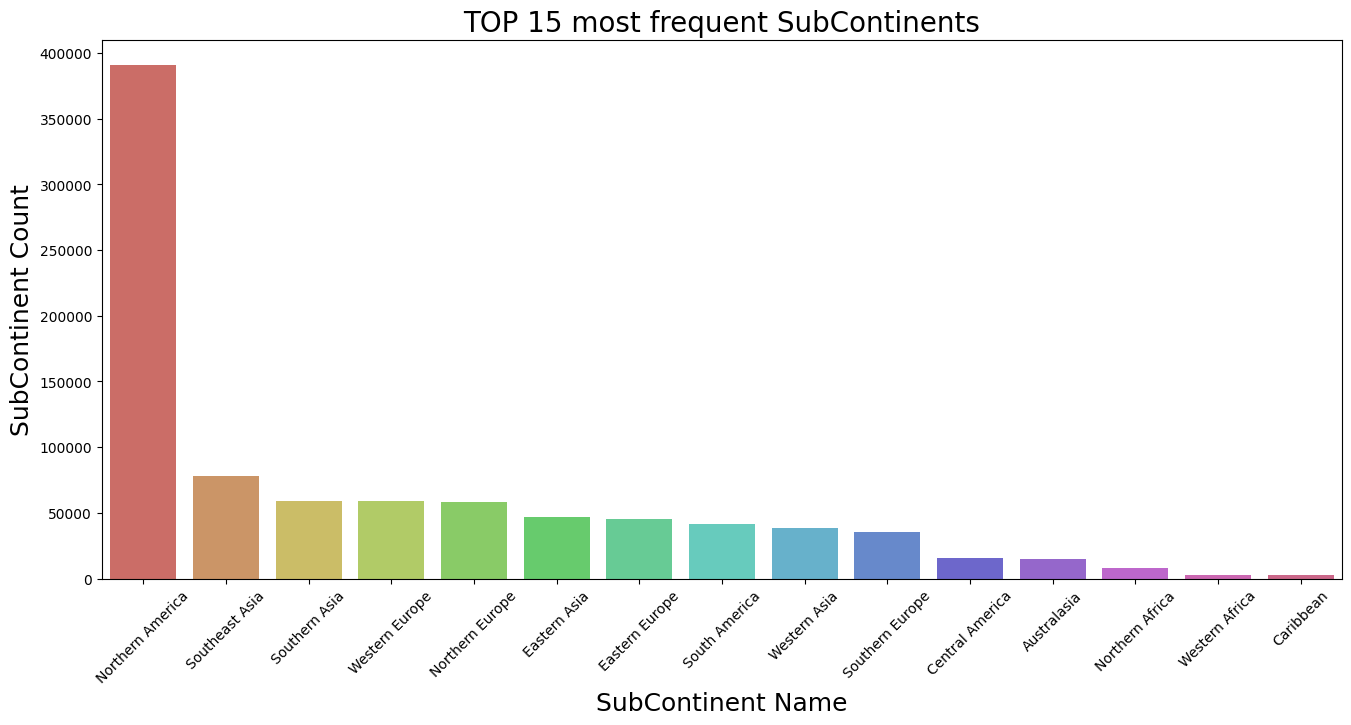

In [55]:
subcontinent_counts = df_train.groupBy("GEONETWORK_SUBCONTINENT").agg(count("*").alias("count")).orderBy(desc("count"))

print("Description of SubContinent count: ")
subcontinent_counts.show(8, truncate=False)


subcontinent_counts_pd = subcontinent_counts.limit(15).toPandas() #chỉ dùng để plotting

plt.figure(figsize=(16, 7))
sns.barplot(x="GEONETWORK_SUBCONTINENT", y="count", data=subcontinent_counts_pd, palette="hls")
plt.title("TOP 15 most frequent SubContinents", fontsize=20)
plt.xlabel("SubContinent Name", fontsize=18)
plt.ylabel("SubContinent Count", fontsize=18)
plt.xticks(rotation=45)
plt.show()

Rất nhiều người dùng tới từ North America.

TOP 5 khu vực với tương đương 70% so với tổng

TOP 1 => Northern America - 44.18%

TOP 2 => Southeast Asia - 8.29%

TOP 3 => Northern Europe - 6.73%

TOP 4 => Southern Asia - 6.33%

TOP 5 => Western Europe - 6.23%

Trình duyệt được sử dụng trong các nước

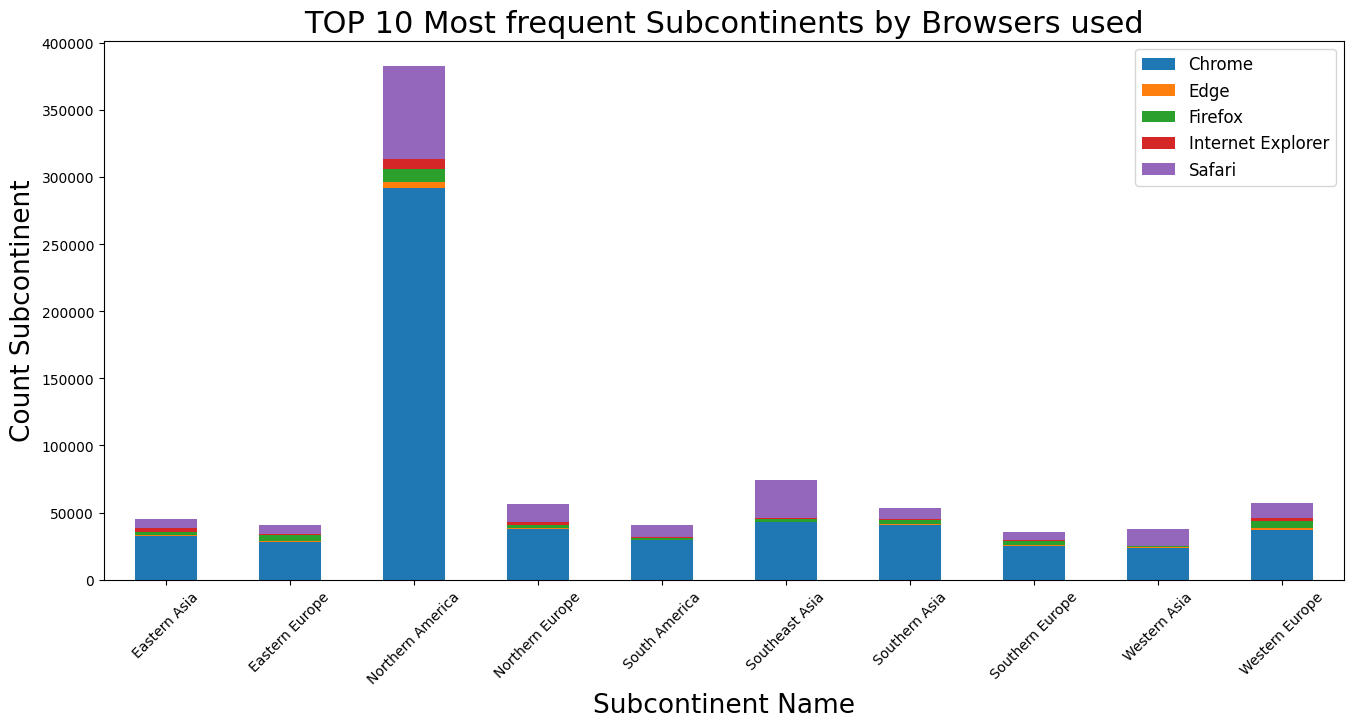

In [56]:
top_10_subcontinents = df_train.groupBy("GEONETWORK_SUBCONTINENT").agg(count("*").alias("count")) \
    .orderBy(desc("count")).limit(10).select("GEONETWORK_SUBCONTINENT").rdd.flatMap(lambda x: x).collect()


top_5_browsers = df_train.groupBy("DEVICE_BROWSER").agg(count("*").alias("count")).orderBy(desc("count")) \
    .limit(5).select("DEVICE_BROWSER").rdd.flatMap(lambda x: x).collect()


filtered_df = df_train.filter(
    (col('GEONETWORK_SUBCONTINENT').isin(top_10_subcontinents)) &
    (col('DEVICE_BROWSER').isin(top_5_browsers))
)


crosstab_eda = pd.crosstab(
    index=filtered_df.select("GEONETWORK_SUBCONTINENT").toPandas()["GEONETWORK_SUBCONTINENT"], #dùng để plotting
    columns=filtered_df.select("DEVICE_BROWSER").toPandas()["DEVICE_BROWSER"]
)


crosstab_eda.plot(kind="bar", figsize=(16, 7), stacked=True)
plt.title("TOP 10 Most frequent Subcontinents by Browsers used", fontsize=22)
plt.xlabel("Subcontinent Name", fontsize=19)
plt.ylabel("Count Subcontinent", fontsize=19)
plt.xticks(rotation=45)
plt.legend(loc=1, prop={'size': 12})
plt.show()

North America có tỷ lệ Safari x Chrome cao.

Firefox tương đối thấp ở North America.

In [57]:
from pyspark.sql.functions import min, max

print('train date:', df_train.select(min('date')).collect()[0][0], 'to', df_train.select(max('date')).collect()[0][0])

train date: 2016-08-01 to 2017-08-01


In [58]:
year = df_train.groupBy('year').agg(count("*").alias("count")).orderBy(desc("count"))
month = df_train.groupBy('month').agg(count("*").alias("count")).orderBy(desc("count"))
weekday = df_train.groupBy('weekday').agg(count("*").alias("count")).orderBy(desc("count"))
day = df_train.groupBy('day').agg(count("*").alias("count")).orderBy(desc("count"))
date = df_train.groupBy('date').agg(count("*").alias("count")).orderBy(desc("count"))

print(year.show(5))

+----+------+
|year| count|
+----+------+
|2017|467260|
|2016|436393|
+----+------+

None


revenue và number of visits theo ngày

In [59]:
import plotly.graph_objs as go
import plotly.io as pio
from pyspark.sql.functions import to_date, date_format, count, sum, col

# Chế độ online tương thích với Colab
pio.renderers.default = 'colab'


df_train = df_train.withColumn("date", to_date(col("date").cast("string"), "yyyy-MM-dd"))

dates_temp = df_train.groupBy("date").agg(count("*").alias("count")).orderBy("date")


dates_temp_sum = df_train.groupBy("date").agg(sum("TOTALS_TRANSACTIONREVENUE").alias("TOTALS_TRANSACTIONREVENUE")).orderBy("date")
dates_temp_count = df_train.filter(col("TOTALS_TRANSACTIONREVENUE") > 0).groupBy("date").agg(count("*").alias("TOTALS_TRANSACTIONREVENUE")).orderBy("date")


# Chỉ đổi sang pandas để plotting
dates_temp_pd = dates_temp.toPandas()
dates_temp_sum_pd = dates_temp_sum.toPandas()
dates_temp_count_pd = dates_temp_count.toPandas()


trace = go.Scatter(
    x=dates_temp_pd['date'],
    y=dates_temp_pd['count'],
    opacity=0.8,
    line=dict(color='blue'),
    name='Visits by day'
)


trace1 = go.Scatter(
    x=dates_temp_sum_pd['date'],
    y=dates_temp_sum_pd['TOTALS_TRANSACTIONREVENUE'],
    line=dict(color='green'),
    name="RevenueLog by day",
    opacity=0.8
)


trace2 = go.Scatter(
    x=dates_temp_count_pd['date'],
    y=dates_temp_count_pd['TOTALS_TRANSACTIONREVENUE'],
    line=dict(color='red'),
    name="Sellings by day",
    opacity=0.8
)

layout = dict(
    title="Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig = go.Figure(data=[trace, trace1, trace2], layout=layout)


fig.show()

Thời gian truy cập theo ngày

In [60]:
date_sales = ['visitHour', 'weekday']
cm = sns.light_palette("green", as_cmap=True)


df_train_pd = df_train.toPandas()  #đổi sang để crosstab

pd.crosstab(df_train_pd[date_sales[0]], df_train_pd[date_sales[1]],
            values=df_train_pd["TOTALS_TRANSACTIONREVENUE"], aggfunc=[np.sum]).style.background_gradient(cmap=cm)

Country

In [61]:
import random

number_of_colors = 20
color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(number_of_colors)]

Description most frequent countrys: 
   GEONETWORK_COUNTRY   count
0       United States  364744
1               India   51140
2      United Kingdom   37393
3              Canada   25869
4             Vietnam   24598
5              Turkey   20522
6            Thailand   20123
7             Germany   19980
8              Brazil   19783
9               Japan   19731
10             France   15832
11             Mexico   13225
12             Taiwan   12996
13          Australia   12698
14             Russia   11662


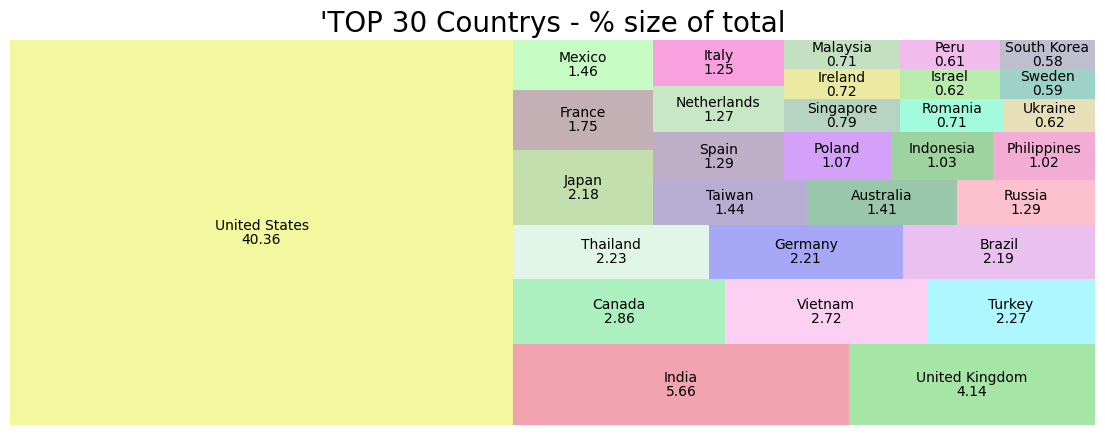

In [62]:
!pip install squarify
import squarify

country_tree = df_train.groupBy("GEONETWORK_COUNTRY").agg(count("*").alias("count")).orderBy("count", ascending=False)
print("Description most frequent countrys: ")


country_tree_pd = country_tree.limit(15).toPandas() #dùng để plotting
print(country_tree_pd)
country_tree_pd = country_tree.limit(30).toPandas()


country_tree_pd['percentage'] = (country_tree_pd['count'] / df_train.count()) * 100
country_tree_pd['percentage'] = country_tree_pd['percentage'].apply(lambda x: "{:.2f}".format(x)) #Lấy 2 chữ số sau dấu '.'
country_tree_pd['percentage'] = pd.to_numeric(country_tree_pd['percentage'])


plt.figure(figsize=(14,5))
number_of_colors = 30
color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(number_of_colors)]



g = squarify.plot(sizes=country_tree_pd['percentage'], label=country_tree_pd['GEONETWORK_COUNTRY'],
                  value=country_tree_pd['percentage'],
                  alpha=.4, color=color)
g.set_title("'TOP 30 Countrys - % size of total",fontsize=20)
g.set_axis_off()
plt.show()

USA cao nhất so với các nước còn lại

City

In [63]:
df_train = df_train.withColumn("GEONETWORK_CITY", when(col("GEONETWORK_CITY") == 'not available in demo dataset', None).otherwise(col("GEONETWORK_CITY")))

Description most frequent Citys: 
+----------------+------+
|GEONETWORK_CITY |count |
+----------------+------+
|NULL            |508229|
|Mountain View   |40884 |
|(not set)       |34262 |
|New York        |26371 |
|San Francisco   |20329 |
|Sunnyvale       |13086 |
|London          |12607 |
|San Jose        |10295 |
|Los Angeles     |8670  |
|Bangkok         |7709  |
|Chicago         |7444  |
|Ho Chi Minh City|7342  |
|Istanbul        |6330  |
|Bengaluru       |5468  |
|Toronto         |5223  |
+----------------+------+
only showing top 15 rows



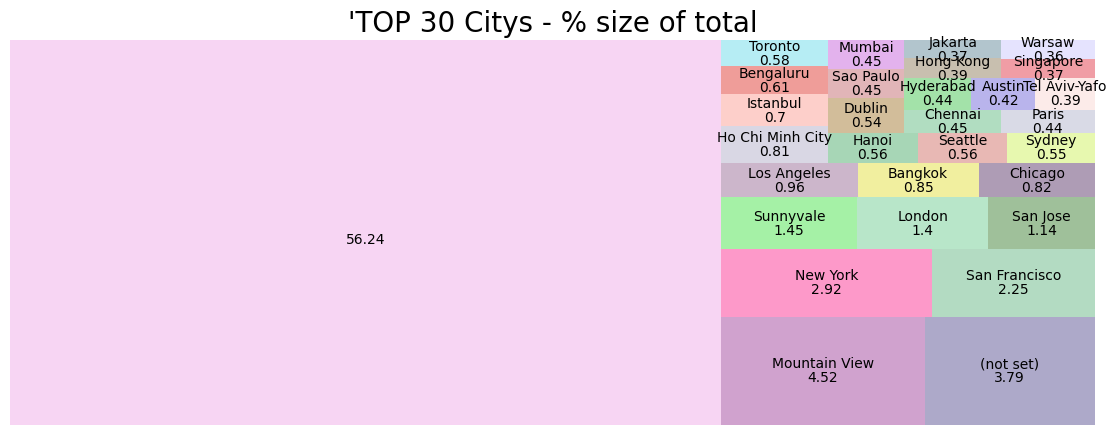

In [64]:
from pyspark.sql.functions import count, desc

city_tree = df_train.groupBy("GEONETWORK_CITY").agg(count("*").alias("count")).orderBy(desc("count"))

print("Description most frequent Citys: ")
city_tree.show(15, truncate=False)

city_tree_pd = city_tree.limit(30).toPandas()  # đổi pandas để plotting


city_tree_pd['percentage'] = (city_tree_pd['count'] / df_train.count()) * 100
city_tree_pd['percentage'] = city_tree_pd['percentage'].apply(lambda x: "{:.2f}".format(x)) #lấy 2 chữ số sau dấu '.'
city_tree_pd['percentage'] = pd.to_numeric(city_tree_pd['percentage'])


plt.figure(figsize=(14, 5))
number_of_colors = 30
color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(number_of_colors)]


g = squarify.plot(sizes=city_tree_pd['percentage'], label=city_tree_pd['GEONETWORK_CITY'],
                  value=city_tree_pd['percentage'],
                  alpha=.4, color=color)
g.set_title("'TOP 30 Citys - % size of total", fontsize=20)
g.set_axis_off()
plt.show()

Giá trị null chiếm hơn 1 nửa

In [65]:
import plotly.graph_objs as go
from plotly.offline import iplot
import random

def PieChart(df_train_pd, column_name, title, limit=15):
    count_pd = df_train_pd[column_name].value_counts().nlargest(limit).reset_index()
    count_pd.columns = [column_name, "count"]


    rev_pd = df_train_pd.groupby(column_name)["TOTALS_TRANSACTIONREVENUE"].sum().nlargest(10).reset_index()
    rev_pd.columns = [column_name, "total_revenue"]


    number_of_colors = 30
    color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


    trace1 = go.Pie(labels=count_pd[column_name], values=count_pd["count"],
                    name="% Accesses", hole=.5, hoverinfo="label+percent+name",
                    showlegend=True, domain={'x': [0, .48]}, marker=dict(colors=color))
    trace2 = go.Pie(labels=rev_pd[column_name], values=rev_pd["total_revenue"],
                    name="% Revenue", hole=.5, hoverinfo="label+percent+name",
                    showlegend=False, domain={'x': [.52, 1]})


    layout = dict(title=title, height=450, font=dict(size=15),
                  annotations=[
                      dict(x=.25, y=.5, text='Visits', showarrow=False, font=dict(size=20)),
                      dict(x=.80, y=.5, text='Revenue', showarrow=False, font=dict(size=20))
                  ])


    fig = dict(data=[trace1, trace2], layout=layout)
    iplot(fig)

In [66]:
PieChart(df_train_pd, "DEVICE_DEVICECATEGORY", "Device Category")

In [67]:
PieChart(df_train_pd, "GEONETWORK_CITY", "Top Cities by Accesses and Revenue", limit=12)

In [68]:
PieChart(df_train_pd, "CHANNELGROUPING", "Channel Grouping Visits and Revenues")

In [69]:
PieChart(df_train_pd, 'GEONETWORK_NETWORKDOMAIN', "Network Domain")

In [70]:
PieChart(df_train_pd, "DEVICE_DEVICECATEGORY", "Device Category")

In [71]:
PieChart(df_train_pd, "TRAFFICSOURCE_MEDIUM", "Trafic Source - Medium")

In [72]:
PieChart(df_train_pd, 'TRAFFICSOURCE_SOURCE', "Visits and Revenue by TOP Sources", limit=8)

In [73]:
country_repayment = ['CHANNELGROUPING', 'weekday']
cm = sns.light_palette("green", as_cmap=True)
df_train_pd = df_train.toPandas() #để crosstab
pd.crosstab(df_train_pd[country_repayment[0]], df_train_pd[country_repayment[1]],
            values=df_train_pd["TOTALS_TRANSACTIONREVENUE"], aggfunc=[np.sum]).style.background_gradient(cmap=cm)

#3. Model

In [74]:
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import col

cat_columns = list(pd.Series(df_train.dtypes, index=df_train.columns)[
    (pd.Series(df_train.dtypes, index=df_train.columns) == 'object') &
    (pd.Series(df_train.dtypes, index=df_train.columns).index != 'VISITSTARTTIME')
].index)

num_columns = ["TOTALS_HITS", "TOTALS_PAGEVIEWS", "VISITNUMBER", "VISITSTARTTIME", "TOTALS_BOUNCES", "TOTALS_NEWVISITS"]


if 'VISITSTARTTIME' not in df_train.columns:
    visitstarttime_cols = [col_name for col_name in df_train.columns if col_name.lower() == 'visitstarttime']
    if visitstarttime_cols:
        df_train = df_train.withColumnRenamed(visitstarttime_cols[0], 'VISITSTARTTIME')
    else:
        raise KeyError("VISITSTARTTIME column not found in the DataFrame")


for column_name in cat_columns:
    df_train[column_name] = LabelEncoder().fit_transform(df_train[column_name])


X = df_train.select([col(c) for c in cat_columns + num_columns])
y = df_train.select('TOTALS_TRANSACTIONREVENUE')

X_pd = X.toPandas()
y_pd = y.toPandas()['TOTALS_TRANSACTIONREVENUE']

In [76]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
X_pd['VISITSTARTTIME'] = pd.to_numeric(pd.to_datetime(X_pd['VISITSTARTTIME']).view('int64')) // 10**9


X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.3, random_state=123)

params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 30,
    "min_child_samples": 100,
    "learning_rate": 0.01,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 2018,
    "verbosity": -1
}

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test)

model = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_val],
                 callbacks=[lgb.early_stopping(stopping_rounds=200),
                            lgb.log_evaluation(100)],
                 )
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.7886
[200]	valid_0's rmse: 1.74658
[300]	valid_0's rmse: 1.73624
[400]	valid_0's rmse: 1.73037
[500]	valid_0's rmse: 1.72871
[600]	valid_0's rmse: 1.72738
[700]	valid_0's rmse: 1.72587
[800]	valid_0's rmse: 1.72535
[900]	valid_0's rmse: 1.72483
[1000]	valid_0's rmse: 1.72481
Did not meet early stopping. Best iteration is:
[986]	valid_0's rmse: 1.7248


In [86]:
import numpy as np

def rmse_to_revenue_error(rmse, mean_revenue):
  return rmse * mean_revenue

rmse = 1.7248
mean_revenue =  df_train.agg({"TOTALS_TRANSACTIONREVENUE": "mean"}).collect()[0][0]

revenue_error = rmse_to_revenue_error(rmse, mean_revenue)
print(f"Estimated revenue error: {revenue_error}")

Estimated revenue error: 30.741735300189475




RMSE (Root Mean Squared Error) thường được ưu tiên hơn MAE (Mean Absolute Error) vì nó đặt trọng số lớn hơn cho các lỗi dự đoán lớn.  Đây là những lý do chính:

1. **Mẫn cảm với lỗi lớn:** RMSE tính bình phương của các sai số, do đó, các lỗi lớn sẽ có ảnh hưởng đáng kể đến giá trị RMSE tổng thể. Trong các trường hợp mà các lỗi lớn là không mong muốn hoặc có chi phí cao, RMSE là một thước đo phù hợp hơn. Ví dụ, trong dự báo tài chính, một sai số lớn có thể dẫn đến tổn thất đáng kể, và RMSE sẽ phản ánh rõ ràng hơn mức độ nghiêm trọng của lỗi này.

2. **Tính toán đạo hàm:** RMSE có đạo hàm liên tục, điều này rất quan trọng trong các thuật toán tối ưu hóa dựa trên gradient (ví dụ: gradient descent). MAE có đạo hàm không liên tục tại điểm sai số bằng 0, làm cho quá trình tối ưu hóa khó khăn hơn.  Do đó, RMSE thường được sử dụng trong các mô hình học máy.

3. **Tính chất thống kê:** RMSE tương đương với độ lệch chuẩn của các lỗi dự đoán.  Điều này cho phép chúng ta sử dụng các kiến thức thống kê để phân tích và hiểu rõ hơn về sự phân tán của các lỗi.

**Khi nào sử dụng MAE:**

MAE có những ưu điểm khi:

* **Các lỗi lớn không quan trọng hơn lỗi nhỏ:** Ví dụ, nếu dự đoán sai nhiệt độ phòng 1-2 độ không gây ra vấn đề lớn, thì MAE là thước đo phù hợp.
* **Dữ liệu có nhiều giá trị ngoại lai:** RMSE bị ảnh hưởng nhiều bởi các giá trị ngoại lai, trong khi MAE ít nhạy cảm hơn.


Tóm lại, lựa chọn giữa RMSE và MAE phụ thuộc vào ngữ cảnh của bài toán. Nếu các lỗi lớn là đáng quan tâm và mô hình cần được tối ưu hóa bằng các phương pháp dựa trên gradient, RMSE thường là lựa chọn tốt hơn.  Nếu các lỗi lớn và nhỏ có tầm quan trọng tương đương hoặc dữ liệu chứa nhiều ngoại lai, MAE có thể là sự lựa chọn phù hợp hơn.


LightGBM (Light Gradient Boosting Machine) là một framework gradient boosting dựa trên cây quyết định, được biết đến với tốc độ huấn luyện nhanh và hiệu suất cao. Nó được sử dụng rộng rãi trong các tác vụ học máy như phân loại và hồi quy.

Cách LightGBM hoạt động:

Xây dựng cây quyết định: LightGBM xây dựng các cây quyết định theo cách tuần tự, trong đó mỗi cây mới cố gắng sửa chữa các lỗi của cây trước đó.

Gradient Boosting: LightGBM sử dụng gradient boosting để kết hợp các cây quyết định thành một mô hình mạnh mẽ hơn. Gradient boosting là một kỹ thuật lặp lại, trong đó mỗi cây mới được huấn luyện để giảm thiểu hàm mất mát của mô hình.
Tăng trưởng theo hướng lá: Không giống như các thuật toán dựa trên cây truyền thống, LightGBM phát triển cây theo hướng lá (leaf-wise growth). Điều này có nghĩa là nó chọn lá có độ lợi (gain) lớn nhất để phát triển, dẫn đến độ chính xác cao hơn với số lần lặp ít hơn.

Histogram-based: LightGBM sử dụng các histogram để lưu trữ dữ liệu, giúp tăng tốc quá trình huấn luyện và giảm sử dụng bộ nhớ.

Ưu điểm của LightGBM:

Tốc độ huấn luyện nhanh: LightGBM được tối ưu hóa để huấn luyện nhanh, đặc biệt là trên các tập dữ liệu lớn.
Hiệu suất cao: LightGBM thường đạt được độ chính xác cao trong các tác vụ học máy.

Sử dụng bộ nhớ thấp: Do sử dụng các histogram, LightGBM sử dụng bộ nhớ hiệu quả hơn so với các thuật toán dựa trên cây khác.

Hỗ trợ song song: LightGBM có thể được huấn luyện song song trên nhiều lõi CPU, giúp tăng tốc quá trình huấn luyện hơn nữa.